# Hands On with Advanced AI & Emerging Applications

## Requirementes

* Definition of al Large Language Model (LLM)
* Definitions of a Prompt

## Retrieval Augmented Generation

RAG (Retrieval-Augmented Generation) is a technique that is used in natural language processing to enhance the capabilities of Large Language Models (LLMs) by integrating information retrieval. It improves the responses of LLMs by incorporating updated or user-defined data the LLM was originally not trained on. A RAG system is typically composed of two processes: Indexing and Retrieval + Generation.

This module uses the [LangChain](https://www.langchain.com/) to interact with LLMs. Langchain is a framework designed to facititate the development of application powered by LLMs. It provides an abstraction layer by decompossing applications as a set of _chains_ made of prompts, models and data sources. Langchain offers libraries to interact with most of the foundational models available in the market.

In this module we will use [Amazon Bedrock](https://aws.amazon.com/bedrock/) which is a fully managed service from AWS that offers access to several foundationsl models. We have chosen [Cloude Sonnet](https://www.anthropic.com/claude/sonnet) from Anthropic as the LLM to use

### Setting up connection to Amazon Bedrock

In [1]:
pip install -q langchain-community langchain_aws

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 1.68.0 requires numpy>=2.0.2, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    model_kwargs=dict(temperature=0),
    region="us-east-1"
)

In [3]:
ai_msg = llm.invoke("Wh is the president of the USA?")
print(ai_msg.content)

The current President of the United States is Joe Biden. He was inaugurated as the 46th President on January 20, 2021, following his victory in the 2020 presidential election.


**Note**: See how Claude Sonnet, an LLM released in February 2024, was trained on data that is no longer accurate.

### Indexing

The indexing phase is responsible for organizing data so that it can be efficiently retrieved by applications powered by large language models (LLMs). To scale Retrieval-Augmented Generation (RAG) systems and handle large datasets, vector databases are commonly used. These databases store information and facilitate efficient data indexing and querying

For the purpose of this section we are going to load the content of the markdown file `acme_guidelines.md`. This document has guidelines of the ficitonal companny `ACME` about the IP addresses schemes to be used in the device configuration.


LanhChain offers a vast number of classes to load documents, ranging from text files (`.txt`) up to HTML and PDF documents. To load the `acme_guidelines.md` file we are goint ot use the class `TextLoader` from the `langchain.document_loaders` library


In [16]:
from langchain.document_loaders import TextLoader

loader = TextLoader("acme_guidelines.md")
documents = loader.load()

#### Splitting
As a best practice, data to be stored on the Vertor DB is usually splitted into smaller _chunks_ of data. This makes the _querying_ stage more efficient as only relevant pieces of the data are retrieved. Additionally large chunks may latter not fit in the LLM context window. 

There are many strategies to split a text. For example, to consider special characters (HTML tags) or punctiation signs. In our example we are using yet another Langchain Class to split a text. The `MarkdownHeaderTextSplitter` allows us to split markdown files based on _Headers_ or _sections_.



In [31]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

md_splits = md_splitter.split_text(documents[0].page_content)
md_splits[3]

Document(metadata={'Header 1': 'Policies', 'Header 2': 'Security protocols'}, page_content='1. The only valid hashing protocol for payload integrity is MD5. This applies for SNMP configurations and authenticated BGP peerings as shown below:  \n```\nsnmp-server user MYUSER MYGROUP v3 auth sha <password> priv aes 256 <password>\n\n```  \n2. The only valid authentication protocol for payload encryption is AES 256')

Another alternative to split text files is to use the class `RecursiveCharacterTextSplitter`, which allows us to define separators between chunks, the size of each chunk and the number of items being overlapped between chunks.

In [25]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n"], 
    chunk_size=200,
    chunk_overlap=0,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(documents)

At this point we can test the content of a chunk by displaying the attribute `page_content`

In [7]:
all_splits[3].page_content

'3. IP Addresses assigned to Router IDs (RID) of routing protocols such as OSPF, EIGRP or BGP must be taken from the CIDR 172.20.0.0/16\n\n    Example: \n    This is a wrong interface configuration'

#### Embedding

The next and last stage in the _Indexing_ process is to actually store the chunks in a Vector DB

As the name implies, a Vector DB saved data as **vectors** not as raw text, therefore and embedding function must transform thus chunks into vectors. In this task we are using an _In-Memory_ Database and [Amazon Titan Embeddings](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-embedding-models.html)

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_aws import BedrockEmbeddings

In [22]:
embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0", region_name='us-east-1')

In [27]:
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(documents=md_splits)

['e07a3ebc-1273-462a-8ba8-1bdd65ea9809',
 'bf008a7c-dcab-42ee-93f3-9cb8ee6aca04',
 '8babc2bd-ffba-49e4-9df6-10a9000dd7e8',
 '4f99c050-3605-48e0-846a-f9cc9771f2a3']

Note that we have used the variable `md_splits` which has the chunks generated by the `MarkdownHeaderTextSplitter`

Let us examine the first two entries on the Vector DB. Note how the dimension of the embeddings in 1024. Only the first three items of each vector are being displayed

In [28]:
for index, (id, doc) in enumerate(vector_store.store.items()):
    if index < 2:
        print(f"{id}: {doc['vector'][0:3]} ({len(doc['vector'])})")


e07a3ebc-1273-462a-8ba8-1bdd65ea9809: [-0.027660029008984566, 0.06223149225115776, -0.004787181504070759] (1024)
bf008a7c-dcab-42ee-93f3-9cb8ee6aca04: [-0.06255853921175003, 0.015993745997548103, 0.0010123404208570719] (1024)


#### Similarity Search

Before actually implement the retrieval stage with the LLM, let us test the _querying_ of the vector VB with the method `similarity_search`

In [30]:
query = "approved security mechanisms"
results = vector_store.similarity_search(query, k=2)
for result in results:
    print(result.page_content)

1. The only valid hashing protocol for payload integrity is MD5. This applies for SNMP configurations and authenticated BGP peerings as shown below:  
```
snmp-server user MYUSER MYGROUP v3 auth sha <password> priv aes 256 <password>

```  
2. The only valid authentication protocol for payload encryption is AES 256
The following document states the configuration policies of the devices of the ACME company


**Note:** See how the similary search takes into account semantic meaning of the text rather than exact words or grammar.

### Retrieval Using LangChain LCEL

In this task, we are going to use LangChain constructs, namely _chains_,  to test the capabilities of the RAG system. As a first step we will invoke the LLMs without using RAG just to realize the difference

In [32]:
from langchain import hub
from langchain.schema.runnable import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

query = "What IPs are allowed in Ethernet Interfaces?"

#### Query without RAG

In [33]:
chain = PromptTemplate.from_template(template = query) |  llm
result = chain.invoke(input={})
result.content

'# IP Addresses Allowed in Ethernet Interfaces\n\nEthernet interfaces can be configured with any valid IP address from the following address spaces:\n\n## IPv4\n- Any address in the range 0.0.0.0 to 255.255.255.255, except for:\n  - Reserved addresses (e.g., 127.0.0.0/8 for loopback)\n  - Multicast addresses (224.0.0.0/4)\n  - Broadcast addresses (like 255.255.255.255)\n  - Other special-purpose addresses\n\n## IPv6\n- Any valid IPv6 address, with common types including:\n  - Global unicast addresses (2000::/3)\n  - Link-local addresses (fe80::/10)\n  - Unique local addresses (fc00::/7)\n\nThe specific IP addresses you should use depend on your network requirements, including whether the interface is for a LAN, WAN connection, or specialized network configuration.'

See how using basic prompt and invoking the LLM directly, the generated response is very generic. The LLM claims that any IP address can be used on a Ethernet Interface

#### Querying with RAG

The idea behind RAG is to provider more context to LLM, so it was use it to generate a response. In our current example the context are the Policies listed in the `acme_guidelines.md` document. We will use a  prompt that apart from specify the question to the LLM also give context to it
```
HUMAN

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:
```

In [34]:
retrieval_qa_chat_prompt = hub.pull("rlm/rag-prompt")
retrieval_qa_chat_prompt.messages[0]

/Users/jgomezve/Documents/Development/ai/neai_module_4/venv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})

Note how the `rag_chain` is made from three components:

1. Two parallel branch to get (a) the `context` and (b) `the question`
2. The RAG promp
3. The LLM

In [36]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
    
rag_chain = (
    {'context': vector_store.as_retriever() | format_docs, 'question' : RunnablePassthrough()} |
    retrieval_qa_chat_prompt |
    llm
)
result = rag_chain.invoke("What IPs are allowed on Ethernet Interfaces")
result.content

'Based on the context, IP addresses on Ethernet interfaces must be taken from the CIDR 10.1.0.0/8. This is shown in the example where a valid interface configuration uses an IP address of 10.1.1.254/24, and another example shows a routed interface with IP address 10.1.2.254/24.'

See how in this execution the LLM considered the content of the `acme_guidelines.md` markdown file

### Retrieval Using LangGraph

In this task, we are going to use [LangGraph](https://www.langchain.com/langgraph) constructs, namely Nodes and Edges, to test the capabilities of the RAG

**Note**: This task asummes that the in-memory VectorDB has already been indexed. 

In [103]:
!pip install -q langgraph graphviz


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


We start defining the _State_ of the grpah. The _State_ is the data being exchanged by the Nodes

In [37]:
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from IPython.display import Image, display

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In our use-case we define two nodes: 

*  Retrieve: It queries the Vector DB using limiraty search from the input question
*  Generate. It leverages the RAG prompt to give context to the LLM and expand its scope

In [38]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"],k=2)
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = retrieval_qa_chat_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Then we build our graph by defining node and edges

In [39]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

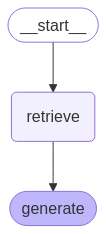

In [40]:
display(Image(graph.get_graph().draw_mermaid_png()))

Finally we invoke our graph

In [41]:
result = graph.invoke({"question": "What IPs are allowed on Ethernet Interfaces"})
result["answer"]

'Ethernet interfaces should use IP addresses from the CIDR 10.1.0.0/8 range. This is specified in the context which states that routable addresses used on physical interfaces (including Ethernet interfaces) must be taken from this range. The example shows a valid configuration with IP address 10.1.1.254/24.'

In [42]:
result["context"]

[Document(id='bf008a7c-dcab-42ee-93f3-9cb8ee6aca04', metadata={'Header 1': 'Policies', 'Header 2': 'Addressing Schema'}, page_content='1. Routable addresses used on physical Interfaces (E.g: Ethernet 1/2), Port-Chanels (port-channel1) or SVI Interfaces must be taken from the CIDR 10.1.0.0/8  \nExample:\nThis is a valid interface configuration\n```\ninterface vlan 123\nno switchport\nip address 10.1.1.254/24\n```  \n2. IP Addresses assigned to Router IDs (RID) of routing protocols such as OSPF, EIGRP or BGP must be taken from the CIDR 172.20.0.0/16  \nExample:\nThis is a valid OSPF process configuration  \n```\nrouter ospf OSPF1\nrouter-id  172.1.1.5\n```'),
 Document(id='8babc2bd-ffba-49e4-9df6-10a9000dd7e8', metadata={'Header 1': 'Policies', 'Header 2': 'Interface description'}, page_content='1. Interfaces must have a description that matches the following convention: <type>_<speed>_<peer_id>, where `type` is `L2` for switches interfaces, `L3` for routed interfaces and `PC` to interfa